## **Tutoriel indicateur en séquence** 

In [1]:
import sys
sys.path.append('../')

In [2]:
from sndstraj.utils.helpers import start_sc
import pyspark.sql.functions as func
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [3]:
from sndstraj.cohorts.cohort import SourceCohort, FilteredCohort, OperationCohort
from sndstraj.cohorts.indicator import Indicator

In [4]:
sqlcontext = start_sc(4)

In [5]:
path2test_data = '../studies/template/data/sample10K.parquet'
path2test_patients = '../studies/template/data/patients10K.parquet'

events = sqlcontext.read.parquet(path2test_data)
patients = sqlcontext.read.parquet(path2test_patients)
events.show(5)
patients.show()

+---------+---------------+--------+--------+------+-------------------+----+
|patientID|       category|   value| groupID|weight|              start| end|
+---------+---------------+--------+--------+------+-------------------+----+
|    pID-0|main_diagnostic|    J960|pfsID-67|   0.0|2017-04-05 02:00:00|null|
|    pID-0|           drug|Anti_Il5|pfsID-37|   0.0|2017-01-31 01:00:00|null|
|    pID-0|main_diagnostic|    J960|pfsID-32|   0.0|2017-05-26 02:00:00|null|
|    pID-0|           drug|Anti_IgE|pfsID-59|   0.0|2017-07-21 02:00:00|null|
|    pID-0|main_diagnostic|    J440|pfsID-83|   0.0|2017-11-28 01:00:00|null|
+---------+---------------+--------+--------+------+-------------------+----+
only showing top 5 rows

+---------+------+-------------------+-------------------+
|patientID|gender|          birthDate|          deathDate|
+---------+------+-------------------+-------------------+
|    pID-0|     1|1938-10-28 00:00:00|               null|
|    pID-1|     1|1921-03-25 01:00:00

In [6]:
events.groupBy('value').count().show(10, False)

+-------------------+-----+
|value              |count|
+-------------------+-----+
|GLQP011            |9445 |
|Sub_Nicotiniques   |9707 |
|Vaccin_Anti_Grippal|9360 |
|GLQP014            |9664 |
|GLQP003            |9629 |
|J441               |11349|
|J440               |11034|
|GLQP002            |9452 |
|Anti_IgE           |9594 |
|GLQP012            |9389 |
+-------------------+-----+
only showing top 10 rows



In [18]:
J960_events = events.filter(func.col('value') == 'J960').select('patientID').distinct().join(events, 'patientID', 'inner')
J960_cohort = SourceCohort(name= 'j960', events=J960_events, characteristics='pop filtered-in on J960')

vaccin_events = events.filter(func.col('value') == 'Vaccin_Anti_Grippal').select('patientID').distinct().join(events, 'patientID', 'inner')
vaccin_cohort = SourceCohort(name= 'vaccin', events=vaccin_events, characteristics='filtered-in on vaccin anti_grippal')

anti_ige_events = events.filter(func.col('value') == 'Anti_IgE').select('patientID').distinct().join(events, 'patientID', 'inner')
anti_ige_cohort = SourceCohort(name='anti_ige', events=anti_ige_events, characteristics='')

vaccin_and_j960 = OperationCohort(name='union_cohort', left_parent=vaccin_cohort, right_parent=J960_cohort, operation_type='union')

exclude_ige = OperationCohort(name='denominateur', left_parent=vaccin_and_j960, right_parent=anti_ige_cohort, operation_type='exclusion', color='red')

numerator_events = exclude_ige.events.filter(func.col("value") == 'GLQP012')
numerator = FilteredCohort(name='numerator', events=numerator_events, parent=exclude_ige, filtered_label='GLQP', color='red')

In [19]:
cohorts = [J960_cohort, anti_ige_cohort, vaccin_cohort, vaccin_and_j960, exclude_ige, numerator]

In [20]:
### Check that names are consistant
test_indicator  = Indicator(
    name='indicator_test')

test_indicator.add_cohorts(cohorts)

In [21]:
test_indicator.execute_dag()

Computing j960 cohort 
size= 6685
Computing anti_ige cohort 
size= 6143
Computing vaccin cohort 
size= 6063
Computing union_cohort cohort 
size= 8663
Computing denominateur cohort 
size= 3336
Computing denominator cohort 
size= 2039


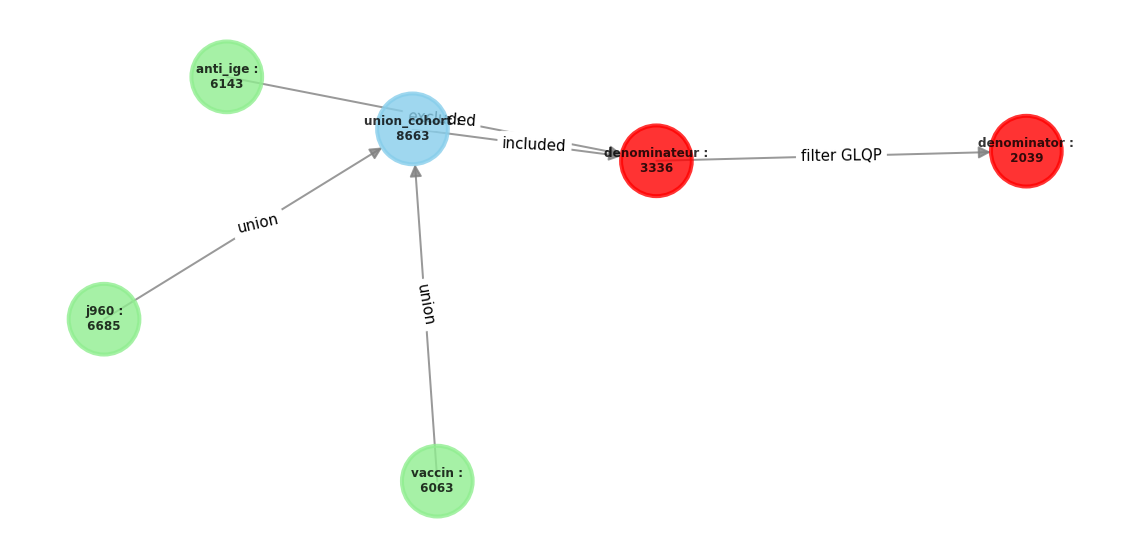

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
test_indicator.plot_flow_chart()

In [23]:
# immediat
test_indicator.compute_taux(
    numerator=numerator,
    denominator=exclude_ige)

(2039, 3336)

In [24]:
import networkx as nx

In [25]:
test_indicator.flow_chart

In [15]:
layout = 'spring'

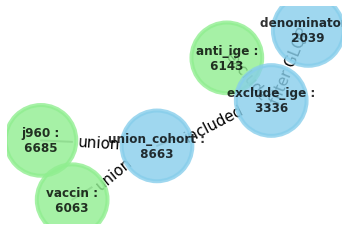

In [17]:
flow_chart = nx.DiGraph()
for cohort_name, cohort in test_indicator.cohorts.items():
    cohort.add_to_flow_chart(flow_chart)
test_indicator.flow_chart = flow_chart
node_labels = nx.get_node_attributes(flow_chart, 'label')
edge_labels = nx.get_edge_attributes(flow_chart, 'operation')
node_colors = nx.get_node_attributes(flow_chart, 'color').values()
if layout == 'spring':
    pos = nx.spring_layout(test_indicator.flow_chart, scale=1)
else:
    pos = nx.spring_layout(test_indicator.flow_chart, scale=1)
nx.draw_networkx_edge_labels(
    G=test_indicator.flow_chart,
    pos=pos,
    edge_labels=edge_labels,
    font_size=15)
flow_plot = nx.draw(
    G=test_indicator.flow_chart,
    pos=pos,
    with_labels=True, labels=node_labels,
    font_weight='bold', font_color="black",
    node_size=5000, node_color=node_colors, node_shape="o", alpha=0.8, linewidths=4,
    width=2, arrowsize=25, edge_color="grey")

flow_plot